In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import SGD

https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/

**Heart Disease Dataset**

In [301]:
file_path = "heart+disease/processed.cleveland.data"
column_names = ['age', 'sex', 'chest pain type','resting blood pressure' , 'cholesteral', 'fasting blood sugar < 120', 'resting ecg', 'max heart rate', 'exercise induced angina', 'oldpeak', 'slope', 'number of vessels colored', 'thal', 'class']
heart_data = pd.read_csv(file_path, delimiter=",", header=None, names=column_names)
# Class: 0 is healathy, 1-4 is disease
for i in range(len(heart_data)):
    if heart_data['class'].iloc[i] != 0:
        heart_data.loc[i, "class"] = 1
    else:
        continue

heart_data['number of vessels colored'] = pd.to_numeric(heart_data['number of vessels colored'], errors='coerce')
heart_data['thal'] = pd.to_numeric(heart_data['thal'], errors='coerce')

heart_data.dropna(inplace=True)
shuffled_heart_data = heart_data.sample(frac=1)
shuffled_heart_data.reset_index(inplace = True, drop = True)

TargetVal = ['class']
Features = ['age', 'sex', 'chest pain type','resting blood pressure' , 'cholesteral', 'fasting blood sugar < 120', 'resting ecg', 'max heart rate', 'exercise induced angina', 'oldpeak', 'slope', 'number of vessels colored', 'thal']

X = shuffled_heart_data[Features].values
Y = shuffled_heart_data[TargetVal].values

PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(X)

X=PredictorScalerFit.transform(X)

<!-- https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/ -->

In [304]:
def FindBestParams(X_train, y_train):
    
    TrialNumber=0
    batch_size_list=[5, 10, 15, 20]
    epoch_list=[5, 10, 50 ,100]

    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    y_train_1 = y_train.ravel()
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1

            classifier = Sequential()
            classifier.add(Dense(units=64, input_dim=13, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dropout(0.2))
            classifier.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dropout(0.2))        
            classifier.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
            # classifier.add(Dropout(0.2))
            # classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
            # classifier.add(Dropout(0.2))
            # classifier.add(Dense(units=2, kernel_initializer='uniform', activation='relu'))
            # classifier.add(Dropout(0.2))
            classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

            # class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train_1)
            # class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
            # learning_rate = tf.Variable(0.001, trainable=False)
            # classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            optimizer = keras.optimizers.Adam(learning_rate=0.001)
            classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            ANN_Model=classifier.fit(X_train,y_train, batch_size=batch_size_trial , epochs=epochs_trial, verbose=0)
            Accuracy = ANN_Model.history['accuracy'][-1]
            

            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', Accuracy)
            
            SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)
    return(SearchResultsData)

#Initializing the classifier
classifier = Sequential()
classifier.add(Dense(units=64, input_dim=13, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.2))        
classifier.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
# classifier.add(Dropout(0.2))
# classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
# classifier.add(Dropout(0.2))
# classifier.add(Dense(units=2, kernel_initializer='uniform', activation='relu'))
# classifier.add(Dropout(0.2))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fetching the accuracy of the training

def evaluate_model(X_test, y_test, features,  threshold=0.5):


    predictions = classifier.predict(X_test)

    test_data = PredictorScalerFit.inverse_transform(X_test)
        
    # Prepare the DataFrame for test data
    testing_data = pd.DataFrame(data=test_data, columns=features)
    testing_data['Class'] = y_test
    testing_data['PredictedClassProb'] = predictions
  
    def prob_threshold(inp_prob):
        return 1 if inp_prob > threshold else 0
    
    testing_data['PredictedClass'] = testing_data['PredictedClassProb'].apply(prob_threshold)
    
    print('Testing Accuracy Results')
    print(metrics.classification_report(testing_data['Class'], testing_data['PredictedClass']))
    
    true_labels = testing_data['Class']
    predicted_labels = testing_data['PredictedClass']
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Convert confusion matrix to a DataFrame for easier visualization
    class_names = [str(label) for label in np.unique(true_labels)]  # Ensure labels are strings
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.show()

Train size .2 (20/80)

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)
# print(X_train.shape, X_test.shape)
ResultsData=FindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.6610169410705566


/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/1828246200.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)


2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.9152542352676392
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 1.0
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 1.0
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.8644067645072937
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.9322034120559692
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.9830508232116699
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 1.0
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.5254237055778503
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.8983050584793091
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.9830508232116699
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 1.0
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.5254237055778503
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.9152542352676392
15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 0.9491525292396545
16 Parameters: batch_size: 20 - epochs: 100 Accuracy: 1.0


  TrialNumber           Parameters  Accuracy
2           3  batch_size5-epoch50       1.0


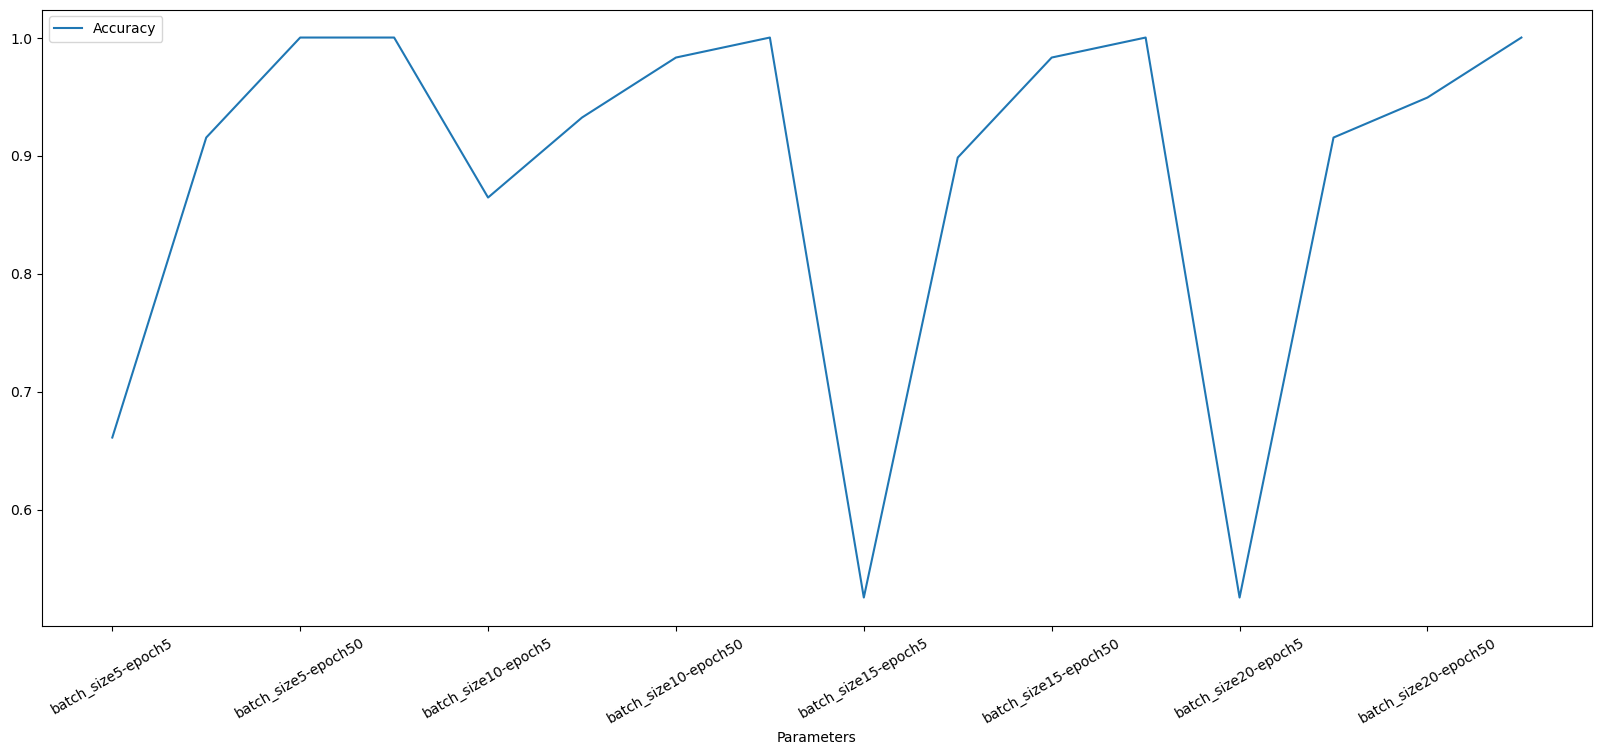

In [306]:

print(ResultsData.sort_values(by='Accuracy', ascending=False).head(1))
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(20,8), kind='line', rot=30);
plt.show()

8/8 [==============================] - 0s 1ms/step
Testing Accuracy Results
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       132
           1       0.74      0.72      0.73       106

    accuracy                           0.76       238
   macro avg       0.76      0.76      0.76       238
weighted avg       0.76      0.76      0.76       238



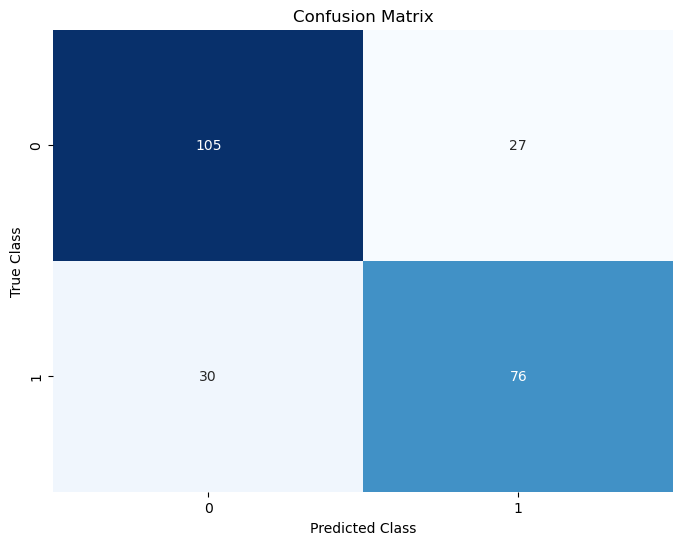

In [307]:
classifier.fit(X_train,y_train, batch_size=5 , epochs=100, verbose=0)
evaluate_model(X_test, y_test, Features, threshold=0.5)

Train size .5 (50/50)

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
# print(X_train.shape, X_test.shape)
ResultsData=FindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.8445945978164673


/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/1828246200.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)


2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.8918918967247009
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.9594594836235046
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 0.9932432174682617
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.8108108043670654
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.8581081032752991
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.9527027010917664
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 0.9864864945411682
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.5540540814399719
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.8581081032752991
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.9459459185600281
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 0.9527027010917664
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.7364864945411682
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.8310810923576355
15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 0.9054054021835327
16 

In [270]:
print(ResultsData.sort_values(by='Accuracy', ascending=False).head(1))
# ResultsData.plot(x='Parameters', y='Accuracy', figsize=(20,8), kind='line', rot=30);
# plt.show()

  TrialNumber            Parameters  Accuracy
3           4  batch_size5-epoch100  0.993243


5/5 [==============================] - 0s 1ms/step
Testing Accuracy Results
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        78
           1       0.80      0.83      0.81        71

    accuracy                           0.82       149
   macro avg       0.82      0.82      0.82       149
weighted avg       0.82      0.82      0.82       149



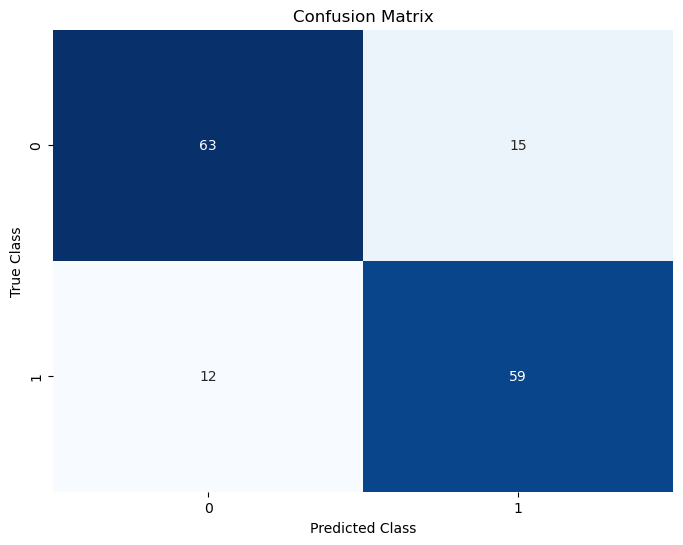

In [271]:
classifier.fit(X_train,y_train, batch_size=5 , epochs=100, verbose=0)
evaluate_model(X_test, y_test, Features, threshold=0.5)

Train size .8 (80/20)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# print(X_train.shape, X_test.shape)
ResultsData=FindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.852320671081543


/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/1828246200.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)


2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.8902953863143921
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.9535865187644958
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 0.9789029359817505
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.8438818454742432
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.8607594966888428
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.9324894547462463
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 0.9704641103744507
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.8354430198669434
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.8607594966888428
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.9198312163352966
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 0.9535865187644958
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.8438818454742432
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.8565400838851929
15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 0.9113923907279968
16 

In [226]:
print(ResultsData.sort_values(by='Accuracy', ascending=False).head(1))
# ResultsData.plot(x='Parameters', y='Accuracy', figsize=(20,8), kind='line', rot=30);
# plt.show()

  TrialNumber            Parameters  Accuracy
3           4  batch_size5-epoch100  0.978903


2/2 [==============================] - 0s 3ms/step
Testing Accuracy Results
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        30
           1       0.81      0.83      0.82        30

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



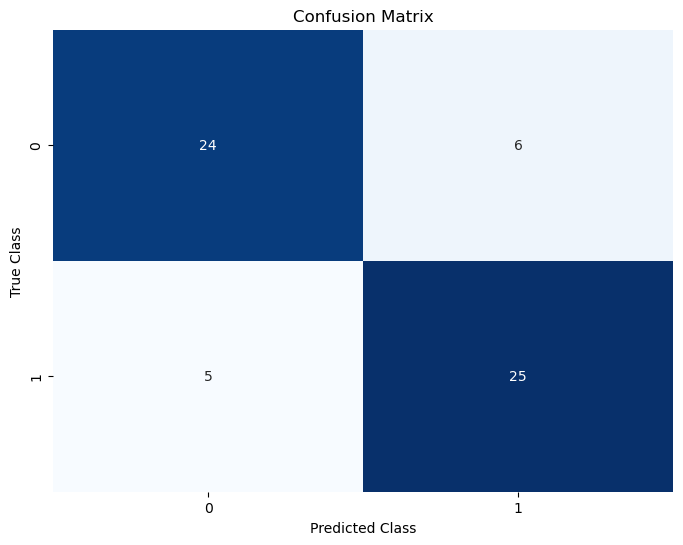

In [227]:
classifier.fit(X_train,y_train, batch_size=5 , epochs=100, verbose=0)
evaluate_model(X_test, y_test, Features, threshold=0.5)

**Parkinsons Dataset**

In [253]:
def FindBestParams(X_train, y_train):
    
    TrialNumber=0
    batch_size_list=[5, 10, 15, 20]
    epoch_list=[5, 10, 50 ,100]

    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    y_train_1 = y_train.ravel()
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1

            classifier = Sequential()
            classifier.add(Dense(units=64, input_dim=11, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dropout(0.2))
            classifier.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dropout(0.2))        
            classifier.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dropout(0.2))
            # classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
            # classifier.add(Dropout(0.2))
            # classifier.add(Dense(units=2, kernel_initializer='uniform', activation='relu'))
            # classifier.add(Dropout(0.2))
            classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

            class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train_1)
            class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
            learning_rate = tf.Variable(0.005, trainable=False)
            classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            # ANN_Model=classifier.fit(X_train,y_train, batch_size=batch_size_trial , epochs=epochs_trial, verbose=0)
            ANN_Model = classifier.fit(X_train, y_train, batch_size=batch_size_trial, epochs=epochs_trial, verbose=0, class_weight=class_weights_dict)

            
            # Fetching the accuracy of the training
            Accuracy = ANN_Model.history['accuracy'][-1]
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', Accuracy)
            
            SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)
    return(SearchResultsData)

#Initializing the classifier
classifier = Sequential()
classifier.add(Dense(units=64, input_dim=11, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.2))        
classifier.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
# classifier.add(Dropout(0.1))
# classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
# classifier.add(Dropout(0.1))
# classifier.add(Dense(units=2, kernel_initializer='uniform', activation='relu'))
# classifier.add(Dropout(0.1))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fetching the accuracy of the training

def evaluate_model(X_test, y_test, features,  threshold=0.5):

    predictions = classifier.predict(X_test)

    test_data = PredictorScalerFit.inverse_transform(X_test)
    

    testing_data = pd.DataFrame(data=test_data, columns=features)
    testing_data['Class'] = y_test
    testing_data['PredictedClassProb'] = predictions
  
    def prob_threshold(inp_prob):
        return 1 if inp_prob > threshold else 0
    
    testing_data['PredictedClass'] = testing_data['PredictedClassProb'].apply(prob_threshold)
    
    print('Testing Accuracy Results')
    print(metrics.classification_report(testing_data['Class'], testing_data['PredictedClass']))
    
    true_labels = testing_data['Class']
    predicted_labels = testing_data['PredictedClass']
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    class_names = [str(label) for label in np.unique(true_labels)]  # Ensure labels are strings
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    

    plt.figure(figsize=(8, 6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.show()


In [254]:
file_path = "parkinsons/parkinsons.data"
parkin_data = pd.read_csv(file_path, delimiter=",", header=0)
parkin_data.drop(columns=parkin_data.columns[0], inplace=True)

parkin_data.dropna(inplace=True)

correlation_matrix = parkin_data.corr()

upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
parkin_data_reduced = parkin_data.drop(columns=to_drop)
shuffled_park_data = parkin_data_reduced.sample(frac=1)
shuffled_park_data.reset_index(inplace = True, drop = True)

TargetVal = ['status']
feat_list = list(parkin_data_reduced.columns)
feat_list.remove('status')
Features = feat_list
X = shuffled_park_data[Features].values
Y = shuffled_park_data[TargetVal].values

PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(X)
X=PredictorScalerFit.transform(X)

Training 20/80

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)
# print(X_train.shape, X_test.shape)
ResultsData=FindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.8717948794364929


/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/1639744176.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)


2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.5641025900840759
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.9743589758872986
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 1.0
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.38461539149284363
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.7948718070983887
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.9487179517745972
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 1.0
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.6153846383094788
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.6666666865348816
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.8717948794364929
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 1.0
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.6153846383094788
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.692307710647583
15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 0.8717948794364929
16 Parameters: batch_size: 20 - epochs: 100 Accu

  TrialNumber             Parameters  Accuracy
3           4   batch_size5-epoch100       1.0
7           8  batch_size10-epoch100       1.0


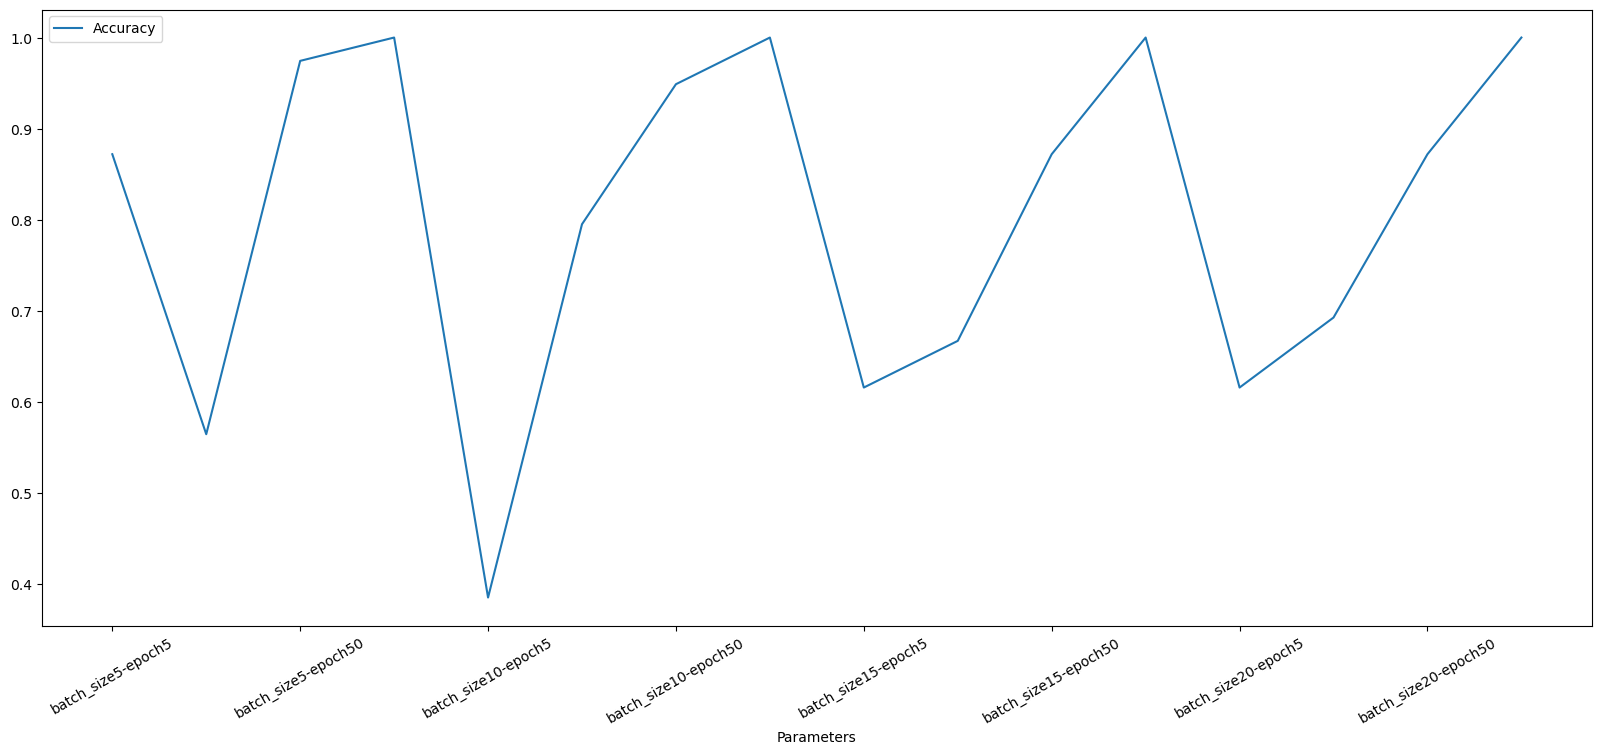

In [256]:
print(ResultsData.sort_values(by='Accuracy', ascending=False).head(2))
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(20,8), kind='line', rot=30);
plt.show()

5/5 [==============================] - 0s 2ms/step
Testing Accuracy Results
              precision    recall  f1-score   support

           0       0.77      0.51      0.62        39
           1       0.85      0.95      0.90       117

    accuracy                           0.84       156
   macro avg       0.81      0.73      0.76       156
weighted avg       0.83      0.84      0.83       156



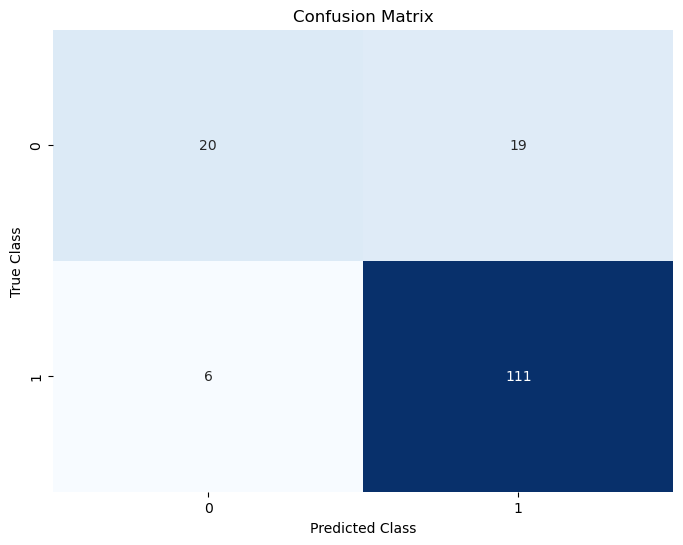

In [257]:
classifier.fit(X_train,y_train, batch_size=5 , epochs=50, verbose=0)
evaluate_model(X_test, y_test, Features, threshold=0.5)

Train size .5 (50/50)

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
# print(X_train.shape, X_test.shape)
ResultsData=FindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.7525773048400879


/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/1639744176.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)


2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.8350515365600586
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.9793814420700073
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 1.0
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.5979381203651428
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.7835051417350769
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.969072163105011
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 0.9896907210350037
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.7525773048400879
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.7319587469100952
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.907216489315033
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 0.9896907210350037
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.7422680258750916
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.8041236996650696
15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 0.9587628841400146
16 Parameters: batch

In [242]:
print(ResultsData.sort_values(by='Accuracy', ascending=False).head(2))
# ResultsData.plot(x='Parameters', y='Accuracy', figsize=(20,8), kind='line', rot=30);
# plt.show()

  TrialNumber            Parameters  Accuracy
6           7  batch_size10-epoch50  0.987179
3           4  batch_size5-epoch100  0.980769


2/2 [==============================] - 0s 3ms/step
Testing Accuracy Results
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.93      0.90      0.92        31

    accuracy                           0.87        39
   macro avg       0.80      0.83      0.81        39
weighted avg       0.88      0.87      0.87        39



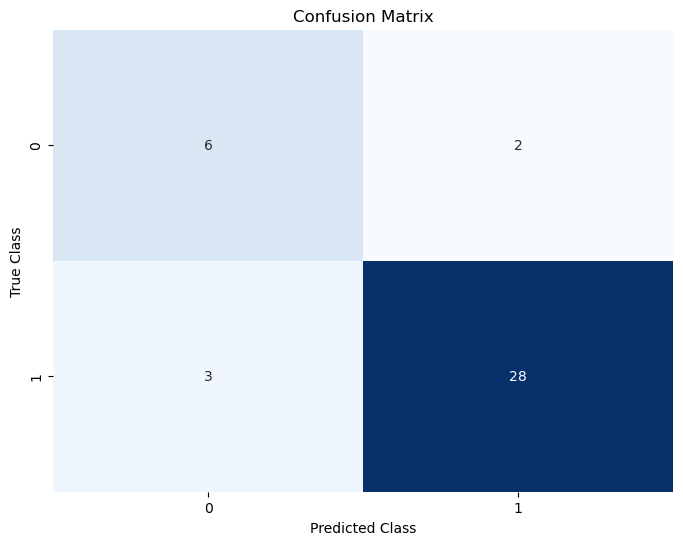

In [243]:
classifier.fit(X_train,y_train, batch_size=10 , epochs=50, verbose=0)
evaluate_model(X_test, y_test, Features, threshold=0.5)

Train size .8 (80/20)

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# print(X_train.shape, X_test.shape)
ResultsData=FindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.7371794581413269


/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/1639744176.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)


2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.8397436141967773
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.9743589758872986
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 0.9935897588729858
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.7307692170143127
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.7820512652397156
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.9743589758872986
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 0.9935897588729858
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.7435897588729858
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.75
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.9551281929016113
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 0.9935897588729858
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.8141025900840759
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.7243589758872986
15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 0.9807692170143127
16 Parameters: ba

In [245]:
print(ResultsData.sort_values(by='Accuracy', ascending=False).head(2))
# ResultsData.plot(x='Parameters', y='Accuracy', figsize=(20,8), kind='line', rot=30);
# plt.show()

  TrialNumber             Parameters  Accuracy
3           4   batch_size5-epoch100   0.99359
7           8  batch_size10-epoch100   0.99359


2/2 [==============================] - 0s 3ms/step
Testing Accuracy Results
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.97      0.90      0.93        31

    accuracy                           0.90        39
   macro avg       0.83      0.89      0.86        39
weighted avg       0.91      0.90      0.90        39



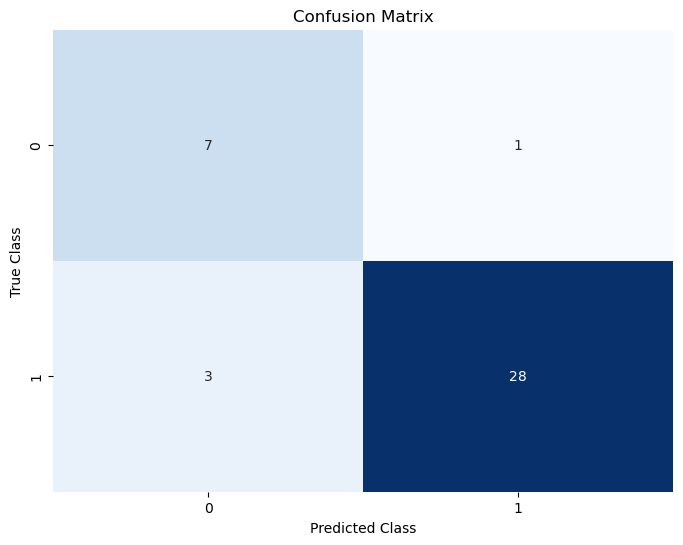

In [241]:
classifier.fit(X_train,y_train, batch_size=10 , epochs=50, verbose=0)
evaluate_model(X_test, y_test, Features, threshold=0.5)

**Breast Cancer Data**

In [282]:
file_path = "breast+cancer/breast-cancer.data"
column_names = ['class', 'age', 'menopause', 'tumor size', 'inv nodes', 'node capes', 'deg malig', 'breast', 'breast quad', 'irradiat'] 
print(len(column_names))
breast_data =  pd.read_csv(file_path, delimiter=",", header=None, names=column_names)

class_map = {'no-recurrence-events': 0, 'recurrence-events' : 1} #0 is healthy

age_mapping = {
    '10-19': 15,
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75,
    '80-89': 85,
    '90-99': 95
}
meno_mapping = {
    'lt40' : 0,
    'ge40' : 1,
    'premeno' : 2
}
size_mapping = {
'0-4' : 2,
'5-9' : 7,
'10-14' : 12,
'15-19' : 17,
'20-24' : 22,
'25-29' : 27,
'30-34' : 32,
'35-39' : 37,
'40-44' : 42,
'45-49' : 47,
'50-54' : 52,
'55-59' : 57
}

node_mapping = {
'0-2' : 2,
'3-5' : 5,
'6-8' : 8,
'9-11' : 11,
'12-14' : 14,
'15-17' : 17,
'18-20' : 20,
'21-23' : 23,
'24-26' : 26,
'27-29' : 29,
'30-32' : 32,
'33-35' : 35,
'36-39' : 39
}
y_n_map = {'yes': 0, 'no':1}
side_map = {'left': 0, 'right':1}
quad_map = {
'left_up' : 0,
'left_low' : 1,
'right_up' : 2,
'right_low' : 3,
'central' : 4,
}
breast_data['class'] = breast_data['class'].replace(class_map)
breast_data['age'] = breast_data['age'].replace(age_mapping)
breast_data['menopause'] = breast_data['menopause'].replace(meno_mapping)
breast_data['tumor size'] = breast_data['tumor size'].replace(size_mapping)
breast_data['inv nodes'] = breast_data['inv nodes'].replace(node_mapping)
breast_data['node capes'] = breast_data['node capes'].replace(y_n_map)
breast_data['breast'] = breast_data['breast'].replace(side_map)
breast_data['breast quad'] = breast_data['breast quad'].replace(quad_map)
breast_data['irradiat'] = breast_data['irradiat'].replace(y_n_map)

breast_data['node capes'] = pd.to_numeric(breast_data['node capes'], errors='coerce')
breast_data['breast quad'] = pd.to_numeric(breast_data['breast quad'], errors='coerce')

breast_data.dropna(inplace=True) #Dropped 9 entries, as Nan
# breast_data.info()

shuffled_breast_data = breast_data.sample(frac=1)
shuffled_breast_data.reset_index(inplace = True, drop = True)


10


/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/2505692527.py:63: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  breast_data['class'] = breast_data['class'].replace(class_map)
/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/2505692527.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  breast_data['age'] = breast_data['age'].replace(age_mapping)
/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/2505692527.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will

In [283]:
Class = ['class']
feat_list = list(breast_data.columns)
feat_list.remove('class')
Features = feat_list

X = shuffled_breast_data[Features].values
Y = shuffled_breast_data[Class].values

PredictorScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(X)

X=PredictorScalerFit.transform(X)

In [284]:
def FindBestParams(X_train, y_train):
    
    TrialNumber=0
    batch_size_list=[5, 10, 15, 20]
    epoch_list=[5, 10, 50 ,100]

    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    y_train_1 = y_train.ravel()
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1

            classifier = Sequential()
            classifier.add(Dense(units=64, input_dim=9, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dropout(0.2))
            classifier.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dropout(0.2))        
            classifier.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dropout(0.2))
            # classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
            # classifier.add(Dropout(0.2))
            # classifier.add(Dense(units=2, kernel_initializer='uniform', activation='relu'))
            # classifier.add(Dropout(0.2))
            classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

            class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train_1)
            class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
            learning_rate = tf.Variable(0.001, trainable=False)
            classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            # ANN_Model=classifier.fit(X_train,y_train, batch_size=batch_size_trial , epochs=epochs_trial, verbose=0)
            ANN_Model = classifier.fit(X_train, y_train, batch_size=batch_size_trial, epochs=epochs_trial, verbose=0, class_weight=class_weights_dict)

            
            # Fetching the accuracy of the training
            Accuracy = ANN_Model.history['accuracy'][-1]
            
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', Accuracy)
            
            SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)
    return(SearchResultsData)

#Initializing the classifier
classifier = Sequential()
classifier.add(Dense(units=64, input_dim=9, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.1))
classifier.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(0.1))        
classifier.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
# classifier.add(Dropout(0.1))
# classifier.add(Dense(units=4, kernel_initializer='uniform', activation='relu'))
# classifier.add(Dropout(0.1))
# classifier.add(Dense(units=2, kernel_initializer='uniform', activation='relu'))
# classifier.add(Dropout(0.1))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Fetching the accuracy of the training

def evaluate_model(X_test, y_test, features,  threshold=0.5):

    predictions = classifier.predict(X_test)

    test_data = PredictorScalerFit.inverse_transform(X_test)
    

    testing_data = pd.DataFrame(data=test_data, columns=features)
    testing_data['Class'] = y_test
    testing_data['PredictedClassProb'] = predictions
  
    def prob_threshold(inp_prob):
        return 1 if inp_prob > threshold else 0
    
    testing_data['PredictedClass'] = testing_data['PredictedClassProb'].apply(prob_threshold)
    
    print('Testing Accuracy Results')
    print(metrics.classification_report(testing_data['Class'], testing_data['PredictedClass']))
    
    true_labels = testing_data['Class']
    predicted_labels = testing_data['PredictedClass']
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    class_names = [str(label) for label in np.unique(true_labels)]  # Ensure labels are strings
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    

    plt.figure(figsize=(8, 6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.show()


Train size .2 (20/80)

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)
# print(X_train.shape, X_test.shape)
ResultsData=FindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.7636363506317139


/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/1083871935.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)


2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.8181818127632141
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.9818181991577148
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 0.9818181991577148
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.6909090876579285
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.7636363506317139
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.9272727370262146
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 0.9636363387107849
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.30909091234207153
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.8363636136054993
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.9090909361839294
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 0.9636363387107849
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.6909090876579285
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.7636363506317139
15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 0.8727272748947144
16

In [286]:
print(ResultsData.sort_values(by='Accuracy', ascending=False).head(1))
# ResultsData.plot(x='Parameters', y='Accuracy', figsize=(20,8), kind='line', rot=30);
# plt.show()

  TrialNumber           Parameters  Accuracy
2           3  batch_size5-epoch50  0.981818


7/7 [==============================] - 0s 1ms/step
Testing Accuracy Results
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       158
           1       0.48      0.41      0.44        64

    accuracy                           0.70       222
   macro avg       0.63      0.61      0.62       222
weighted avg       0.69      0.70      0.69       222



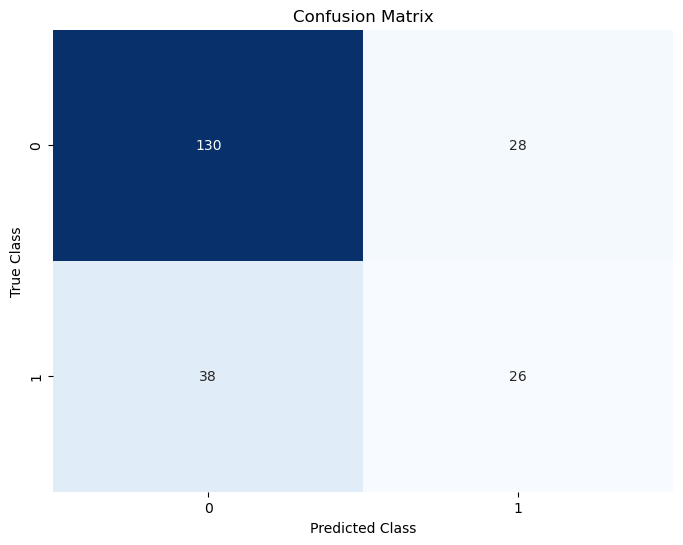

In [287]:
classifier.fit(X_train,y_train, batch_size=5 , epochs=100, verbose=0)
evaluate_model(X_test, y_test, Features, threshold=0.5)

Train size .5 (50/50)

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
# print(X_train.shape, X_test.shape)
ResultsData=FindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.7898550629615784


/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/1083871935.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)


2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.760869562625885
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.8550724387168884
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 0.9275362491607666
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.717391312122345
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.8188405632972717
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.8478260636329651
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 0.9202898740768433
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.6449275612831116
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.6086956262588501
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.8695651888847351
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 0.9057971239089966
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.717391312122345
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.6739130616188049
15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 0.8913043737411499
16 Par

In [289]:
print(ResultsData.sort_values(by='Accuracy', ascending=False).head(1))
# ResultsData.plot(x='Parameters', y='Accuracy', figsize=(20,8), kind='line', rot=30);
# plt.show()

  TrialNumber            Parameters  Accuracy
3           4  batch_size5-epoch100  0.927536


5/5 [==============================] - 0s 1ms/step
Testing Accuracy Results
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       103
           1       0.44      0.44      0.44        36

    accuracy                           0.71       139
   macro avg       0.63      0.63      0.63       139
weighted avg       0.71      0.71      0.71       139



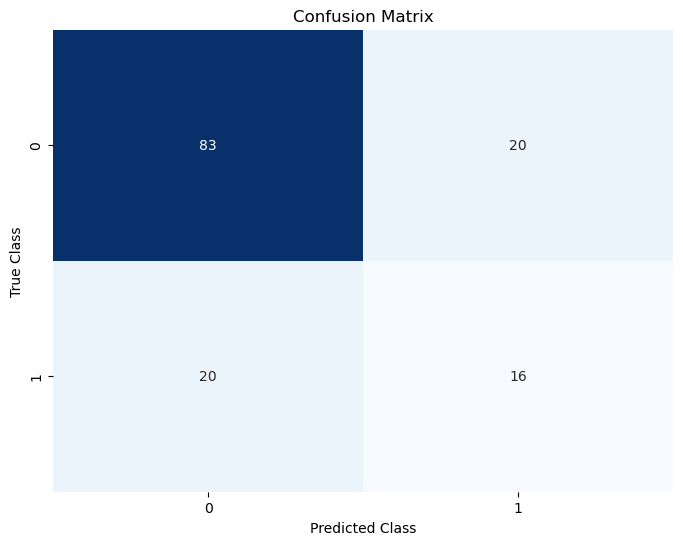

In [290]:
classifier.fit(X_train,y_train, batch_size=5 , epochs=100, verbose=0)
evaluate_model(X_test, y_test, Features, threshold=0.5)

Train size .8 (80/20)

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# print(X_train.shape, X_test.shape)
ResultsData=FindBestParams(X_train, y_train)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.7104072570800781


/var/folders/1r/9xqq4jbj1bxc93bgtfzf_0w40000gn/T/ipykernel_37415/1083871935.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  SearchResultsData = pd.concat([SearchResultsData,pd.DataFrame(data=[[TrialNumber, f'batch_size{batch_size_trial}-epoch{epochs_trial}', Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'])], ignore_index=True)


2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.7692307829856873
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.8506787419319153
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 0.9230769276618958
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.6968325972557068
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.7375565767288208
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.7692307829856873
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 0.8325791954994202
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.733031690120697
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.7285068035125732
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.7963801026344299
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 0.8959276080131531
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.7058823704719543
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.7013574838638306
15 Parameters: batch_size: 20 - epochs: 50 Accuracy: 0.7782805562019348
16 P

In [292]:
print(ResultsData.sort_values(by='Accuracy', ascending=False).head(1))
# ResultsData.plot(x='Parameters', y='Accuracy', figsize=(20,8), kind='line', rot=30);
# plt.show()

  TrialNumber            Parameters  Accuracy
3           4  batch_size5-epoch100  0.923077


2/2 [==============================] - 0s 2ms/step
Testing Accuracy Results
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.65      0.69      0.67        16

    accuracy                           0.80        56
   macro avg       0.76      0.77      0.76        56
weighted avg       0.81      0.80      0.81        56



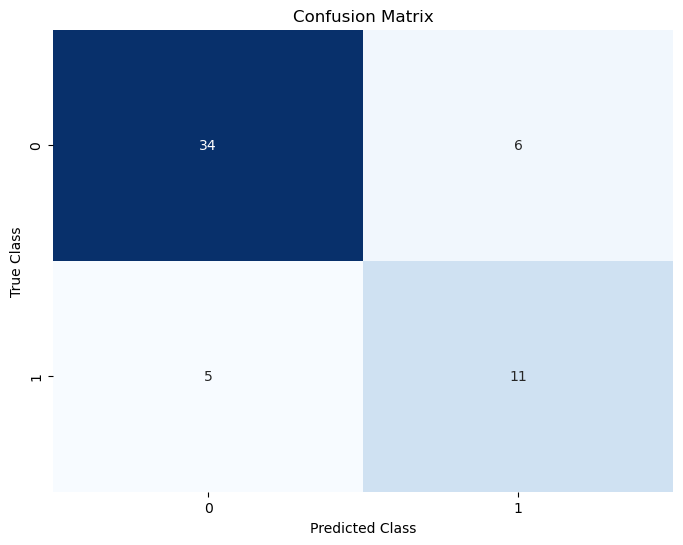

In [294]:
classifier.fit(X_train,y_train, batch_size=5 , epochs=100, verbose=0)
evaluate_model(X_test, y_test, Features, threshold=0.5)